In [1]:
# Cameron Schultz 
# ckschult@usc.edu
# Github: ckschultz

In [2]:
import sklearn
import pandas as pd
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import math
import seaborn as sb
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline

# import sys
# !{sys.executable} -m pip install xgboost
import xgboost as xgb
from xgboost import XGBRegressor





# Question 1

## Create df for Decision Tree

Read all data, create new class variable (for 4 possible diagnosis classes)

In [3]:
fp = '../data/diagnosis.csv'
df = pd.read_csv(fp, encoding='utf-16', sep='\t', 
                 names=['Temperature','Nausea','Lumbar','Urine','Micturition','Urethra','d1_Bladder','d2_Pelvis'],
                 header=None, decimal=',')
d1 = []
d2 = []
newcol = []
for row in df['d1_Bladder']:
    if row == 'yes':
        d1.append(1)
    else:
        d1.append(0)

for row in df['d2_Pelvis']:
    if row == 'yes':
        d2.append(1)
    else:
        d2.append(0)
   

for i in range(len(d1)):
    newcol.append(d1[i] + 2*d2[i])

df['class'] = newcol

# mlb.fit_transform([pd.unique(df['d1_Bladder']), pd.unique(df['d2_Pelvis'])])
# df = pd.concat([df, col])

df = df.replace('yes', 1)
df = df.replace('no', 0)
df

,Temperature,Nausea,Lumbar,Urine,Micturition,Urethra,d1_Bladder,d2_Pelvis,class
0,35.5,0,1,0,0,0,0,0,0
1,35.9,0,0,1,1,1,1,0,1
2,35.9,0,1,0,0,0,0,0,0
3,36.0,0,0,1,1,1,1,0,1
4,36.0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
115,41.4,0,1,1,0,1,0,1,2
116,41.5,0,0,0,0,0,0,0,0
117,41.5,1,1,0,1,0,0,1,2
118,41.5,0,1,1,0,1,0,1,2


Drop columns, new y = multilabel class. 

In [4]:
dtdf = df.drop('d1_Bladder', axis=1)
dtdf = dtdf.drop('d2_Pelvis', axis=1)
dtdf

,Temperature,Nausea,Lumbar,Urine,Micturition,Urethra,class
0,35.5,0,1,0,0,0,0
1,35.9,0,0,1,1,1,1
2,35.9,0,1,0,0,0,0
3,36.0,0,0,1,1,1,1
4,36.0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
115,41.4,0,1,1,0,1,2
116,41.5,0,0,0,0,0,0
117,41.5,1,1,0,1,0,2
118,41.5,0,1,1,0,1,2


# 1B)

# Decision Tree

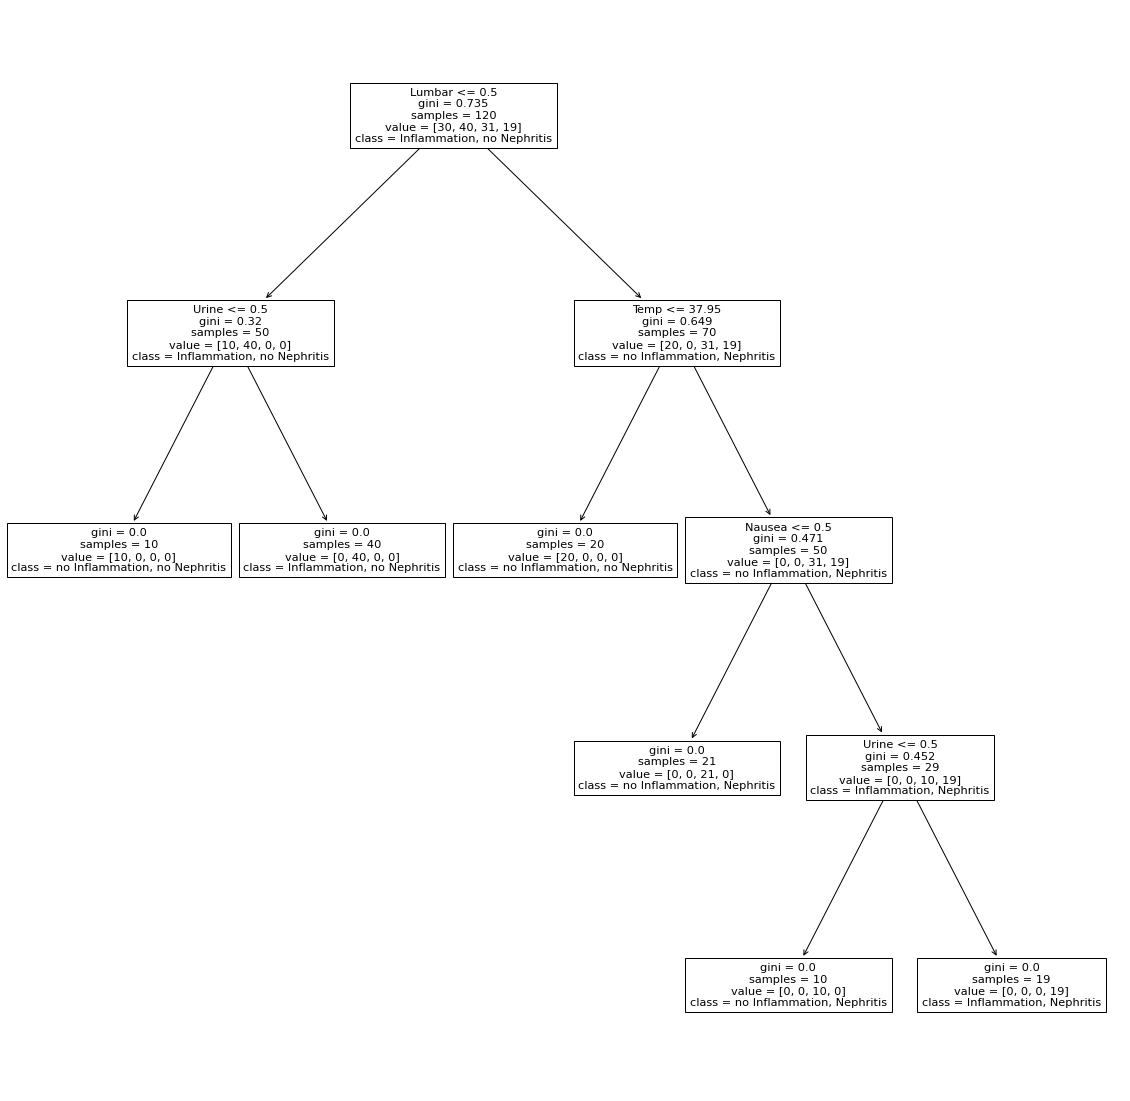

In [5]:
xtree = dtdf.drop('class', axis=1)
ytree = dtdf['class']

dtc = tree.DecisionTreeClassifier()
dtc = dtc.fit(xtree, ytree)

plt.figure(figsize=(20, 20))
tree.plot_tree(dtc, feature_names=['Temp', 'Nausea', 'Lumbar', 'Urine', 'Micturition', 'Urethra'], 
               class_names=['no Inflammation, no Nephritis', 'Inflammation, no Nephritis', 
                            'no Inflammation, Nephritis', 'Inflammation, Nephritis'])
plt.show()


# 1C)

# If-Then Pseudocode

In [6]:
def tree_to_pseudo(tree, feature_names):
#     """
# 	Outputs a decision tree model as if/then pseudocode
	
# 	Parameters:
# 	-----------
# 	tree: decision tree model
# 		The decision tree to represent as pseudocode
# 	feature_names: list
# 		The feature names of the dataset used for building the decision tree
# 	"""

    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth=0):
        indent = "  " * depth
        if (threshold[node] != -2):
            print(indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
            if left[node] != -1:
                recurse (left, right, threshold, features, left[node], depth+1)
                print(indent,"} else {")
                if right[node] != -1:
                    recurse (left, right, threshold, features, right[node], depth+1)
                print(indent,"}")
        else:
            print(indent,"return " + str(value[node]))

    recurse(left, right, threshold, features, 0)
    
    
tree_to_pseudo(dtc, ['Temp', 'Nausea', 'Lumbar', 'Urine', 'Micturition', 'Urethra'])


 if ( Lumbar <= 0.5 ) {
   if ( Urine <= 0.5 ) {
     return [[10.  0.  0.  0.]]
   } else {
     return [[ 0. 40.  0.  0.]]
   }
 } else {
   if ( Temp <= 37.95000076293945 ) {
     return [[20.  0.  0.  0.]]
   } else {
     if ( Nausea <= 0.5 ) {
       return [[ 0.  0. 21.  0.]]
     } else {
       if ( Urine <= 0.5 ) {
         return [[ 0.  0. 10.  0.]]
       } else {
         return [[ 0.  0.  0. 19.]]
       }
     }
   }
 }


In [7]:
# xtrain, xtest, ytrain, ytest = train_test_split(xtree, ytree, random_state=0, test_size=0.2)
path = dtc.cost_complexity_pruning_path(xtree, ytree)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.         0.09816667 0.13333333 0.182      0.22291667]


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

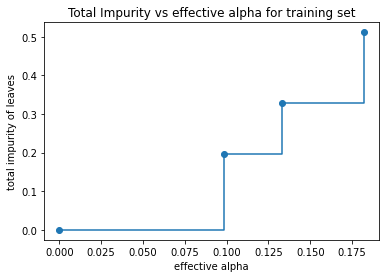

In [8]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [9]:
grid_vals = {'ccp_alpha': ccp_alphas, 'random_state':[42]}
cv_dtc = DecisionTreeClassifier()
cvdtc = GridSearchCV(cv_dtc, param_grid=grid_vals, cv=5, scoring='neg_mean_squared_error')
cvdtc.fit(xtree, ytree)

mse = cvdtc.cv_results_['mean_test_score'] 
alpha = cvdtc.cv_results_['param_ccp_alpha'] 

resultsdf = {'alpha':alpha, 'MSE':(-1)*mse}
resultsdf = pd.DataFrame(resultsdf)
resultsdf

,alpha,MSE
0,0.0,0.166667
1,0.098167,0.350000
2,0.133333,0.408333
3,0.182,0.875000
4,0.222917,0.891667


#### As we can see, the best alpha = 0.098167. (Note: alpha = 0 is an unpruned tree, so we ignore). 

# Pruned Tree
## (Refit tree with best alpha)

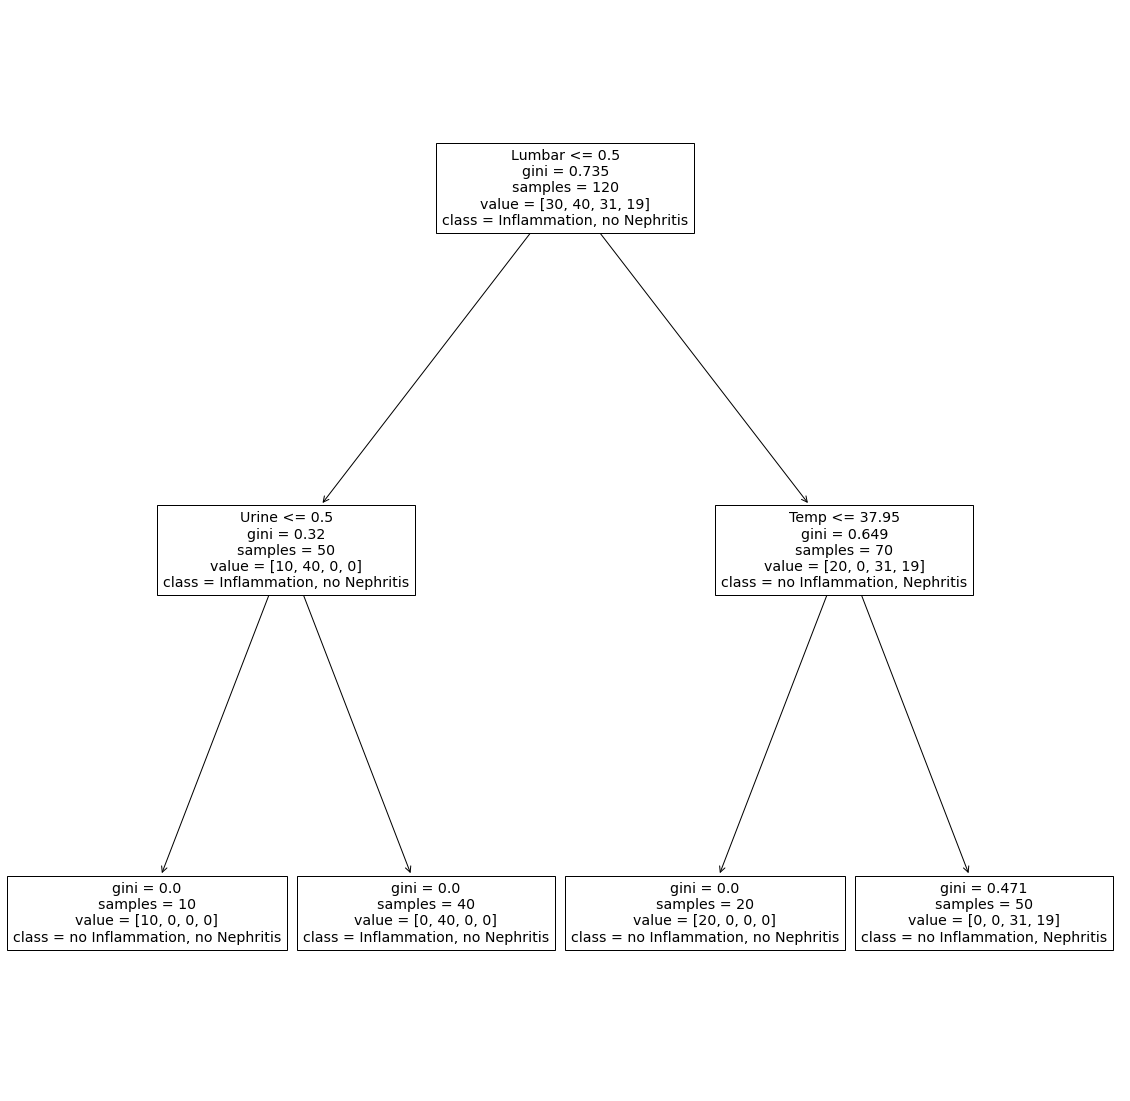

In [10]:
finaldtc = tree.DecisionTreeClassifier(ccp_alpha=0.098167)
finaldtc = finaldtc.fit(xtree, ytree)

plt.figure(figsize=(20, 20))
tree.plot_tree(finaldtc, feature_names=['Temp', 'Nausea', 'Lumbar', 'Urine', 'Micturition', 'Urethra'], 
               class_names=['no Inflammation, no Nephritis', 'Inflammation, no Nephritis', 
                            'no Inflammation, Nephritis', 'Inflammation, Nephritis'])
plt.show()


## Pruned (Final) Decision Tree Decision Rules

In [11]:
tree_to_pseudo(finaldtc, ['Temp', 'Nausea', 'Lumbar', 'Urine', 'Micturition', 'Urethra'])


 if ( Lumbar <= 0.5 ) {
   if ( Urine <= 0.5 ) {
     return [[10.  0.  0.  0.]]
   } else {
     return [[ 0. 40.  0.  0.]]
   }
 } else {
   if ( Temp <= 37.95000076293945 ) {
     return [[20.  0.  0.  0.]]
   } else {
     return [[ 0.  0. 31. 19.]]
   }
 }


# Question 2

In [12]:
fp2 = '../data/communities.csv'
df = pd.read_csv(fp2, sep=',', header=None)
dfx = df.drop([127], axis=1)
dfx = dfx.drop([0, 1, 2, 3, 4], axis=1) # drop non-predictive attributes
dfx = dfx.replace('?', np.nan)

# iterative imputer did not converge; using simple imputer instead

# imp_mean = IterativeImputer(random_state=42, max_iter=25)
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# imp_mean = imp_mean.fit(dfx)
# imp_mean.transform(dfx)




## 2B) Data Imputation 
#### (Using SimpleImputer; IterativeImputer did not converge, even when increasing max_iter)

In [13]:
# iterative imputer did not converge; using simple imputer instead
imp_mean = IterativeImputer(random_state=42, max_iter=25)
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean = imp_mean.fit(dfx)
dfx = imp_mean.transform(dfx)
dfx = pd.DataFrame(dfx)
dfx[127] = df[127] # add prediction column back
dfx

,0,1,2,3,4,5,6,7,8,9,...,113,114,115,116,117,118,119,120,121,127
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.01,0.28,0.05,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.20,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.08,0.32,0.18,0.080000,0.060000,0.780000,0.000000,0.91,0.280000,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.020000,0.020000,0.790000,0.000000,0.22,0.180000,0.19


## Split into Train and Test

In [14]:
# SPLIT INTO TRAIN/TEST SETS 
traindf = dfx.iloc[:1495, :]
testdf = dfx.iloc[1495:, :]



## 2C) Correlation Matrix

In [15]:
corr_matrix = dfx.corr()
print(corr_matrix)

          0         1         2         3         4         5         6    \
0    1.000000 -0.046148  0.231178 -0.300845  0.181603  0.156218  0.006368   
1   -0.046148  1.000000 -0.067109 -0.235907  0.201996  0.468659  0.520461   
2    0.231178 -0.067109  1.000000 -0.794389 -0.106738 -0.066581  0.122338   
3   -0.300845 -0.235907 -0.794389  1.000000 -0.270266 -0.444166 -0.194015   
4    0.181603  0.201996 -0.106738 -0.270266  1.000000  0.266743 -0.025020   
..        ...       ...       ...       ...       ...       ...       ...   
118 -0.061583 -0.006426 -0.082660  0.052940  0.032389  0.024366  0.000652   
119  0.076527 -0.000280  0.010987 -0.033209  0.065424  0.025956  0.011271   
120  0.466352 -0.094368  0.260793 -0.276234  0.101888  0.125353  0.001301   
121 -0.035576 -0.054562  0.022237 -0.006323 -0.011619  0.002234 -0.076589   
127  0.367157 -0.034923  0.631264 -0.684770  0.037622  0.293050  0.060477   

          7         8         9    ...       113       114       115  \
0  

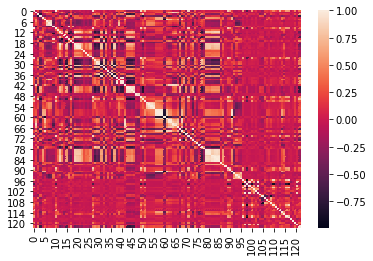

In [16]:
sb.heatmap(corr_matrix);

## 2D) Coefficient of Variation

In [17]:
cofv = lambda x: np.std(x, ddof=1)/np.mean(x) # ddof for sample std

cvs = dfx.apply(cofv)
cvs = list(cvs) # list of coefficients of variation
print(cvs)

[2.203502536390972, 0.3532983018683109, 1.4109203963756864, 0.3237815624993411, 1.3591621938222074, 1.614277791710685, 0.36583986883972397, 0.29069288841904145, 0.4951605143654288, 0.42344170889026195, 2.0017436381957676, 0.6388488712113656, 0.5797533935755996, 0.3277100586060616, 0.7000301156104908, 0.35923994722340613, 0.36851263032540155, 0.699030504203365, 0.3496390828575848, 0.527731885342079, 0.545633428419145, 0.5075521907214038, 0.5894690036844645, 0.8096850868666168, 0.6061938508790911, 0.6706445725467309, 0.4739597186074789, 2.304969714852185, 0.7539801744357952, 0.6756002166771716, 0.5282862664983298, 0.5784008385663657, 0.5561327984953394, 0.3473272454905018, 0.5105803413512793, 0.39822567574896933, 0.5084613109923771, 0.42210585589961375, 0.3955833690023806, 0.40381161614997696, 0.3592727036887422, 0.37146815336205474, 0.31695474768257587, 0.3306111369901614, 0.3324758807131056, 0.3294258419264571, 0.32855094726896933, 0.33624845001518155, 0.3327221175201113, 2.99419644948

# 2E) Scatter and Box Plots

In [18]:
a = math.floor(128**(1/2))
print("We need to select the top", a, "features with the highest coefficient of variation.")

We need to select the top 11 features with the highest coefficient of variation.


In [19]:
maxcvs = []
for i in range(11):
    maxcvs.append(max(cvs))
    cvs.remove(max(cvs))
    
# for i in range(len(cvs)):
#     print(i)

In [20]:
# print(maxcvs)
cvs = dfx.apply(cofv)
cvs = list(cvs)

maxCVSIndices = []
for maxval in maxcvs:
    maxCVSIndices.append(cvs.index(maxval))

# maxCVSIndices.append(127) # add y column back 
print(maxCVSIndices)


[90, 89, 49, 51, 120, 27, 0, 10, 71, 113, 5]


In [37]:
sigdf = dfx.iloc[:, maxCVSIndices]
# dfx
# print(len(sigdf.columns))
sigdf.loc[:, len(sigdf.columns)] = df[127]
# NOTE: here, feature 11 is the prediction (y) column

### Scatterplot

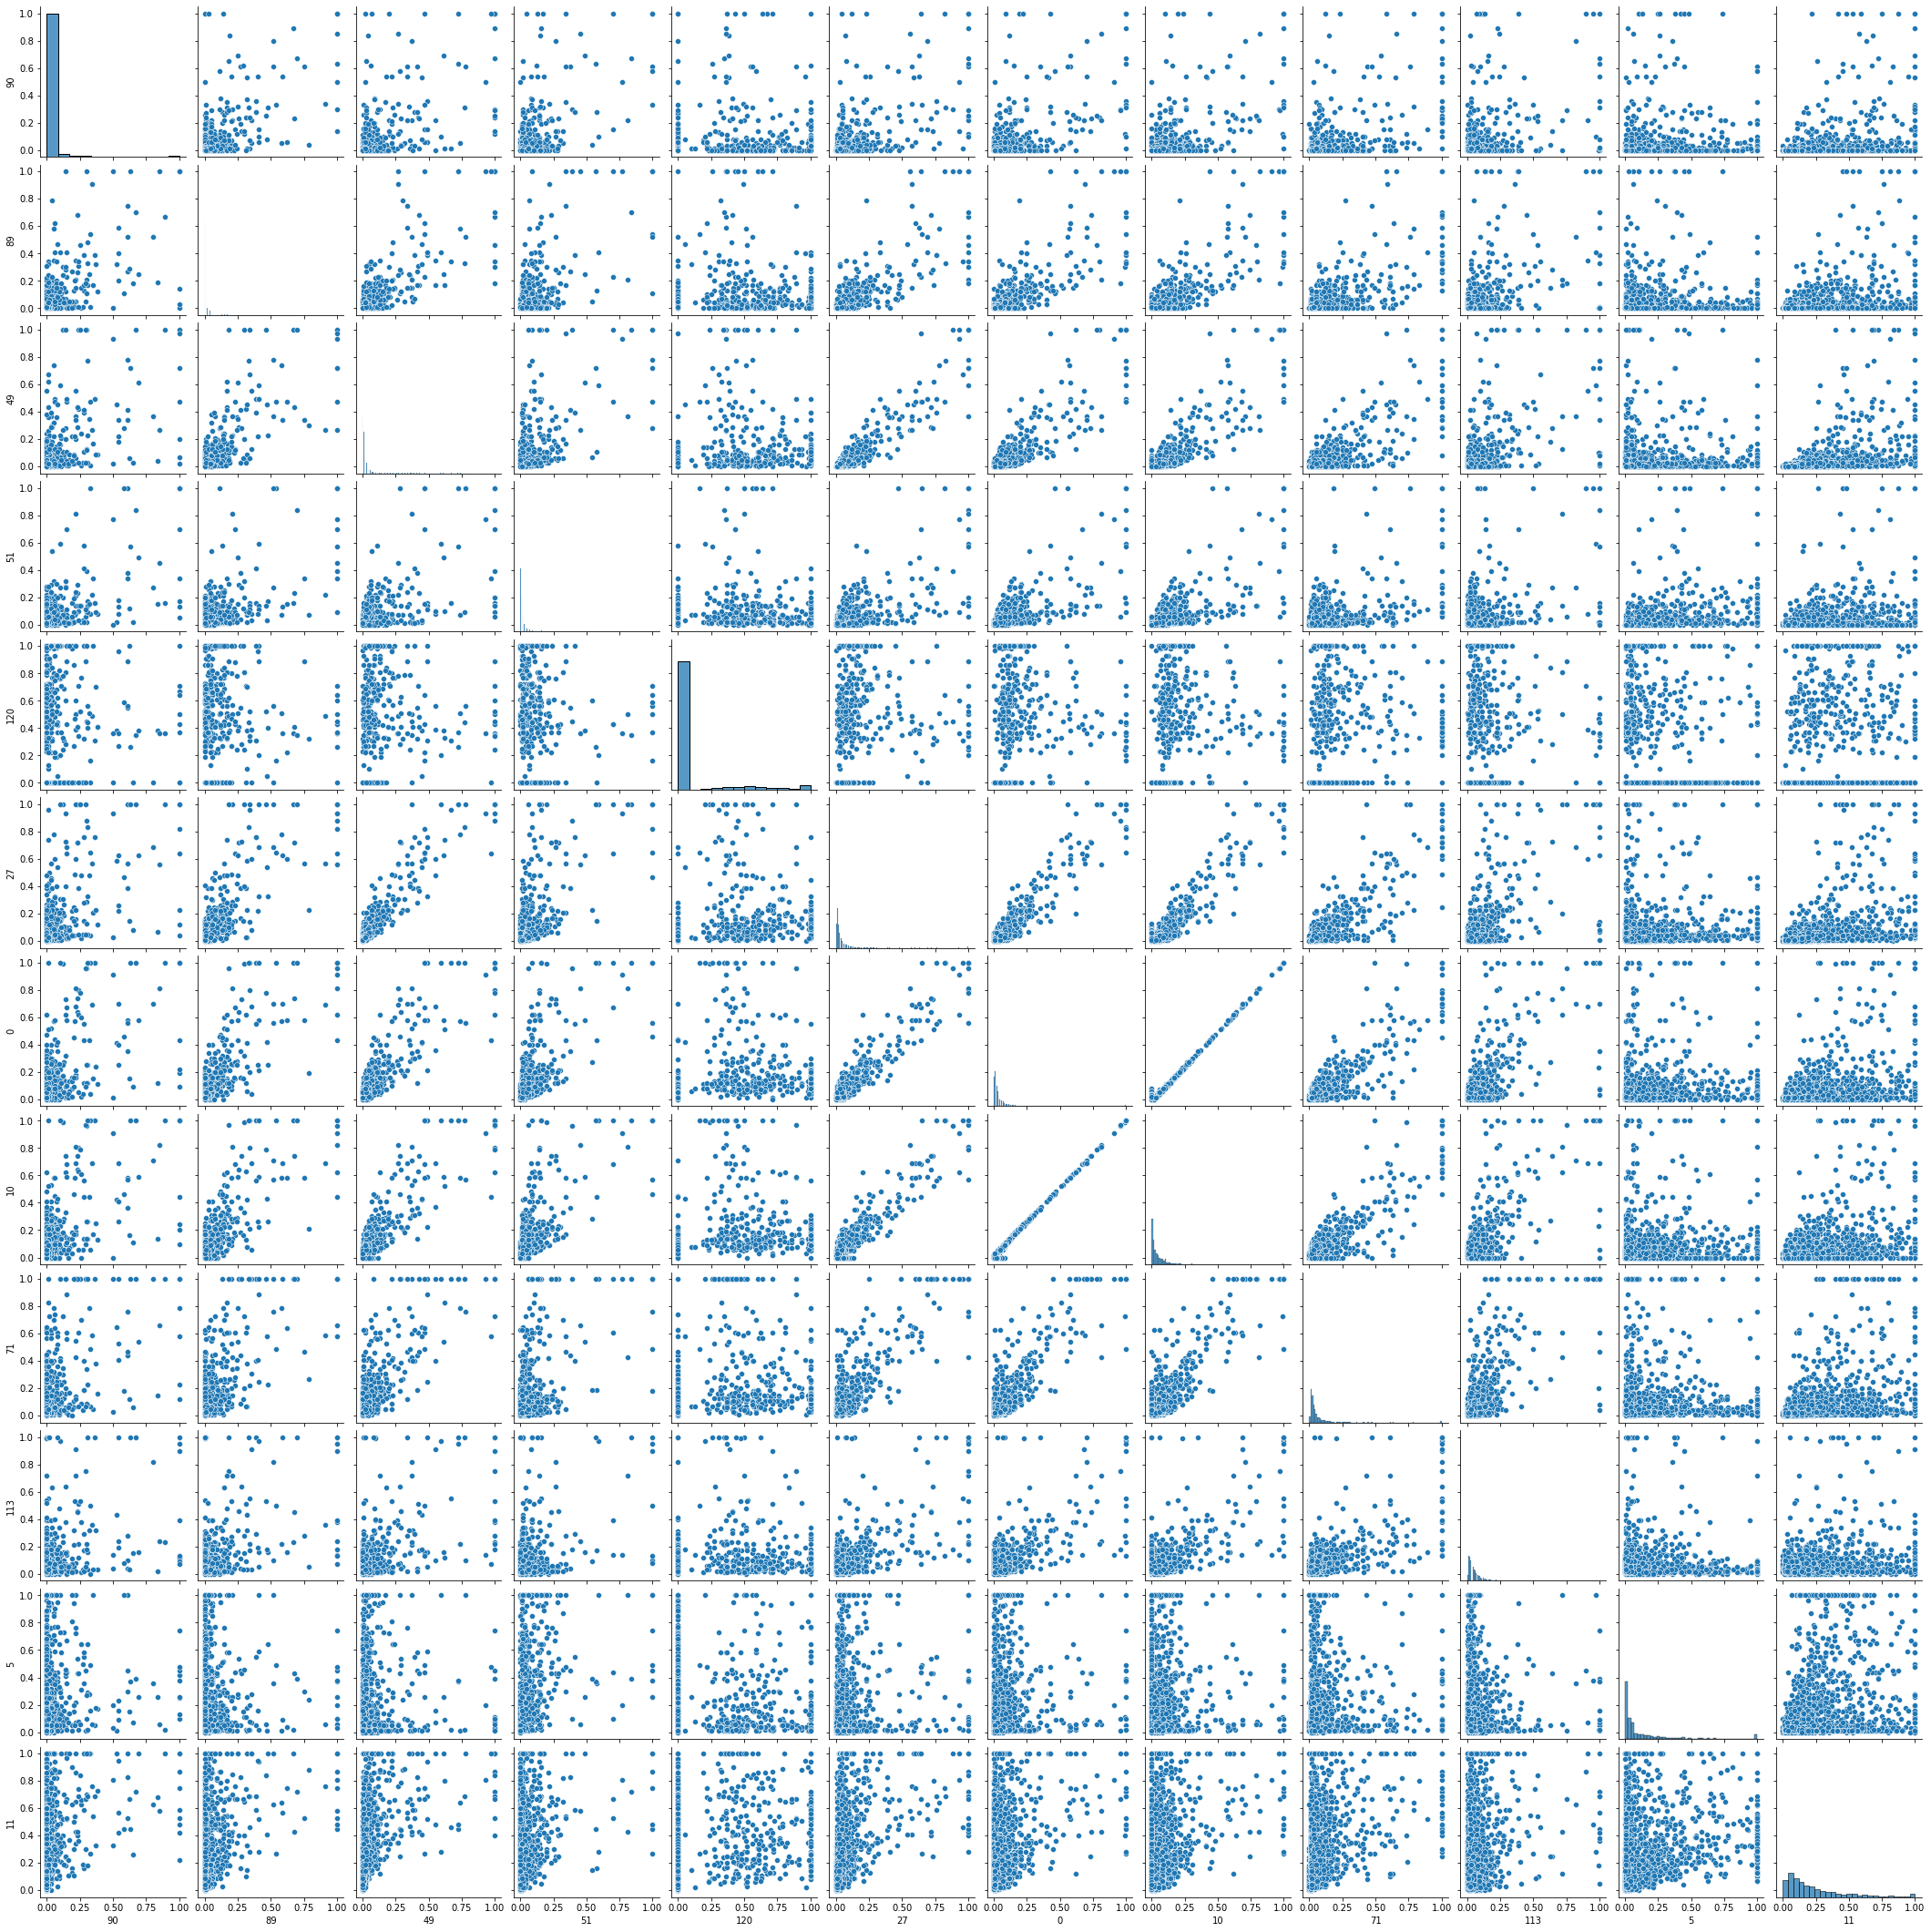

In [22]:
sigdf
crossplot = sb.pairplot(sigdf)
plt.show(crossplot)

### Boxplot

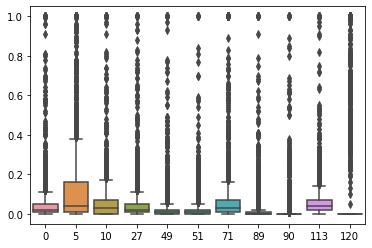

In [23]:
sigdf = sigdf.reindex(sorted(sigdf.columns), axis=1)
sb.boxplot(data=sigdf.drop(11, axis=1))
plt.show()
# sb.boxplot(x=[90, 89], y = 11, data = sigdf)
# fig, (ax1, ax2) = plt.subplots(2)
# fig.suptitle('Vertically stacked subplots')
# ax1.plot(x, y)
# ax2.plot(x, -y)

Some features (ex: 0 and 10 in the pairplot) are very strongly correlated, and form a near perfect y=x regression line. Other features, for example, most features along with feature 120, have little to no correlation at all. The correlation with feature 11 (the prediction column; y values) is also very little. Similarly, for the boxplots, quartile ranges/standard deviations of individual features does not give us much information about how significant each feature is in predicting y (feature 11). There is not much we can conclude about the significance of these features from these graphs alone. 

# 2F) Linear Regression, Test Error
## The following linear regressions all use the full dataset (all features)
This is to test the accuracy of each linear model, especially for the Ridge and Lasso regressions, which automatically perform feature selection with their L1/L2 penalties. 

In [24]:
# SPLIT INTO TRAIN/TEST SETS, ALL FEATURES

trainx = traindf.drop(127, axis=1)
trainy = traindf[127]

testx = testdf.drop(127, axis=1)
testy = testdf[127]


In [25]:
# # SPLIT INTO TRAIN/TEST SETS 
# sigtrain = sigdf.iloc[:1495, :]
# sigtest = sigdf.iloc[1495:, :]

# # SPLIT X, Y
# sigtrainx = sigtrain.drop(11, axis=1)
# sigtrainy = sigtrain[11]

# sigtestx = sigtest.drop(11, axis=1)
# sigtesty = sigtest[11]
# trainx

In [26]:
reg = LinearRegression()
reg.fit(trainx, trainy)
predict_y_test = reg.predict(testx)
mse = mean_squared_error(testy, predict_y_test)
print("TEST MSE (Normal Linear Reg, all features):", mse)


TEST MSE (Normal Linear Reg, all features): 0.7897255274469274


#### Test MSE is high because of this one outlier value, where the prediction for y is -18.835 and the actual test y value is 0.79. This is likely caused by a data entry error, but I will leave it in the sample. 

In [58]:
i = list(predict_y_test).index(min(predict_y_test))
print(i)
# print(min(predict_y_test))
print(list(testy)[i])
print(list(predict_y_test)[i])
# print(list(testx.iloc[i, :]))
# print(list(testx.iloc[i-1, :]))
# print(reg.coef_)

# for i in range(len(reg.coef_)):
#     if abs(testx.iloc[i,:][i] * reg.coef_[i]) > 1: 
#         print(i)

145
0.79
-18.83511808888423


# 2G) Ridge Regression, Test Error

In [28]:
ridgelambdas = []
for i in range(-4, 5):
    ridgelambdas.append(10**i)
# print(ridgelambdas)


rreg_cv = RidgeCV(alphas=ridgelambdas).fit(trainx, trainy)
y_pred_rr = rreg_cv.predict(testx)
testmse = mean_squared_error(testy, y_pred_rr)
print("TEST MSE (Ridge Regression, all features):", testmse)

# print(rreg_cv.coef_)


TEST MSE (Ridge Regression, all features): 0.017737081104305


# 2H) Lasso Regression, Test Error, Variable Selection
### Raw Data

In [29]:
lasso_cv = LassoCV(alphas=ridgelambdas).fit(trainx, trainy)
y_pred_lasso = lasso_cv.predict(testx)
testmse = mean_squared_error(testy, y_pred_lasso)

coefs = lasso_cv.coef_
coefsindices = []
for i in range(len(coefs)):
    if coefs[i] != 0:
        coefsindices.append(i)
    
print("Features Selected by Model:", coefsindices)
print("TEST MSE (Lasso Regression, Non-Standardized Features):", testmse)


Features Selected by Model: [2, 4, 6, 7, 9, 11, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 26, 28, 29, 31, 33, 34, 36, 38, 39, 40, 44, 45, 46, 48, 49, 50, 51, 55, 59, 61, 63, 64, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 82, 85, 86, 87, 88, 89, 90, 91, 94, 99, 100, 102, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120]
TEST MSE (Lasso Regression, Non-Standardized Features): 0.017790185551932514


### Standardized Data

In [30]:
# REPEAT AFTER STANDARDIZING DATA 
mms = preprocessing.MinMaxScaler()
xtrain_mms = mms.fit_transform(trainx)
xtest_mms = mms.fit_transform(testx)

lasso_cv_std = LassoCV(alphas=ridgelambdas).fit(xtrain_mms, trainy)
y_pred_lasso_std = lasso_cv_std.predict(xtest_mms)
testmse_mms = mean_squared_error(testy, y_pred_lasso_std)

coefs_std = lasso_cv_std.coef_
coefsindices_std = []
for i in range(len(coefs_std)):
    if coefs_std[i] != 0:
        coefsindices_std.append(i)
    
print("Features Selected by Model:", coefsindices_std)
print("TEST MSE (Lasso Regression, Standardized Features):", testmse_mms)


Features Selected by Model: [2, 4, 6, 7, 9, 11, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 26, 28, 29, 31, 33, 34, 36, 38, 39, 40, 44, 45, 46, 48, 49, 50, 51, 55, 59, 61, 63, 64, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 82, 85, 86, 87, 88, 89, 90, 91, 94, 99, 100, 102, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120]
TEST MSE (Lasso Regression, Standardized Features): 0.01785051163971301


### Comparisons
The features selected by the raw data Lasso regression and the standardized data Lasso regression are the same, but the Test MSE for the raw data Lasso regression is lower. Standardized features increased the test MSE. 

# 2I) PCR Model

In [31]:
ms = []
for i in range(1, len(trainx.columns)+1):
    ms.append(i)
    
    
pca = PCA()
scaler = StandardScaler()
linear = LinearRegression()

pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("linear", linear)])
param_grid = {'pca__n_components': ms}
search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error').fit(trainx, trainy)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


Best parameter (CV score=-0.019):
{'pca__n_components': 95}


### Refit PCR Model with n=95 Components

In [32]:
pcr = make_pipeline(StandardScaler(), PCA(n_components=95), LinearRegression())
pcr.fit(trainx, trainy)
predictions = pcr.predict(testx)
mse = mean_squared_error(testy, predictions)
print("Test MSE:", mse)
print("Number of predictions: 95")

Test MSE: 0.0183946072248941
Number of predictions: 95


# 2J) Boosting Tree

In [33]:
xgbalphas = np.logspace(0, 2, 20) # pick range of alphas to cross validate
print(xgbalphas)

[  1.           1.27427499   1.62377674   2.06913808   2.6366509
   3.35981829   4.2813324    5.45559478   6.95192796   8.8586679
  11.28837892  14.38449888  18.32980711  23.35721469  29.76351442
  37.92690191  48.32930239  61.58482111  78.47599704 100.        ]


In [34]:
grid_vals = {'reg_alpha': xgbalphas, 'random_state':[42]}
xgbr = xgb.XGBRegressor(verbosity=0)
gs = GridSearchCV(xgbr, param_grid=grid_vals, cv=5, scoring='neg_mean_squared_error')
gs.fit(trainx, trainy)

mse = gs.cv_results_['mean_test_score'] 
alpha = gs.cv_results_['param_reg_alpha'] 

# resultsdf = {'alpha':alpha, 'MSE':(-1)*mse}
# resultsdf = pd.DataFrame(resultsdf)
# resultsdf

In [35]:
print("Best parameter (CV score=%0.3f):" % gs.best_score_)
print(gs.best_params_)

Best parameter (CV score=-0.021):
{'random_state': 42, 'reg_alpha': 3.3598182862837818}


In [36]:
xgbr = xgb.XGBRegressor(verbosity=0, reg_alpha=gs.best_params_['reg_alpha'])
xgbr.fit(trainx, trainy)
pred = xgbr.predict(testx)
mse = mean_squared_error(testy, pred)
print("Test MSE (L1 Penalized Gradient Boosting Tree, Best Alpha =", gs.best_params_['reg_alpha'], "):", mse)

Test MSE (L1 Penalized Gradient Boosting Tree, Best Alpha = 3.3598182862837818 ): 0.017607076020952926
